In [31]:
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib as mpl
import scipy
from perlin_noise import PerlinNoise
import cv2
import random
import pandas as pd
from glob import glob

COLOR = '#bbccd5'
BG = '#23272a'
# print(mpl.rcParams.keys()) # see all params
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR
mpl.rcParams['figure.facecolor'] = BG
mpl.rcParams['figure.figsize'] = [16, 9]

## Helper Functions

In [2]:
def get_img(name, loc='imgs'):
    location = os.path.join(loc, name)
    img = plt.imread(location)
    if img.dtype == 'uint8':
        img = img.astype(np.float64) / 255
    return img

def scale_values(img):
    norm = (img - np.min(img)) 
    return norm / max(np.max(norm), 0.1)

def to_greyscale(img):
    if img.dtype == 'uint8':
        img = img / 256
    new_img = img[:,:,:3] # rgba -> rgb
    return np.repeat(np.mean(new_img, axis=2)[:, :, np.newaxis], 3, axis=2)

def side_by_side(img_a, img_b):
    size = 10
    ratio = img_a.shape[0] / img_a.shape[1]
    fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(2 * size, size * ratio))
    
    axs[0].imshow(img_a)
    axs[1].imshow(img_b)
    
def clip(img, bounds=(0,1)):
    return np.clip(bounds[0], img, bounds[1])

## Some examples

Images are stored in imgs/examples number to match the image where a is for after and b is for before. So 1b and 1a are the same location before and after respectively.

source of example images: https://www.lemonde.fr/en/les-decodeurs/article/2022/07/22/before-and-after-satellite-images-of-the-massive-fires-in-gironde-france_5991052_8.html

In [3]:
def compare(before, after):
    diff = after - before # get the difference
    
    # I try to perform some filtering by removing non white colors (as smoke is mostly white/grey)
    ranges = diff.max(axis=2) - diff.min(axis=2)
    ranges = np.repeat(ranges[:,:,np.newaxis], 3, axis=2)
    diff = diff * (ranges < 0.1) * (to_greyscale(diff) > 0.1)
    
    diff = scale_values(diff) # scale the values to make it easier to see
    
    return diff
    
def plot_trio(l_small, r_small, center_large, labels =('Before' , 'After', 'Difference')):
    fig = plt.figure(figsize=(16,12))
    fig.tight_layout()
    
    plt.subplot(2, 1, 1)
    plt.title(labels[2])
    plt.imshow(center_large)

    plt.subplot(2, 2, 3)
    plt.title(labels[0])
    plt.imshow(l_small)

    plt.subplot(2, 2, 4)
    plt.title(labels[1])
    plt.imshow(r_small)

In [4]:
examples = []
for i in range(1, 1000):
    try:
        pair = []
        for version in 'ba':
            pair.append(get_img(os.path.join('examples', f'{i}{version}.jpg')))
        examples.append(pair)
    except FileNotFoundError:
        print(f'found {i - 1} images')
        break

found 4 images


In [5]:
for i, example in enumerate(examples):
    diff = compare(*example)
    examples[i].append(diff)

## Comparison Plots (you can colapse this section)

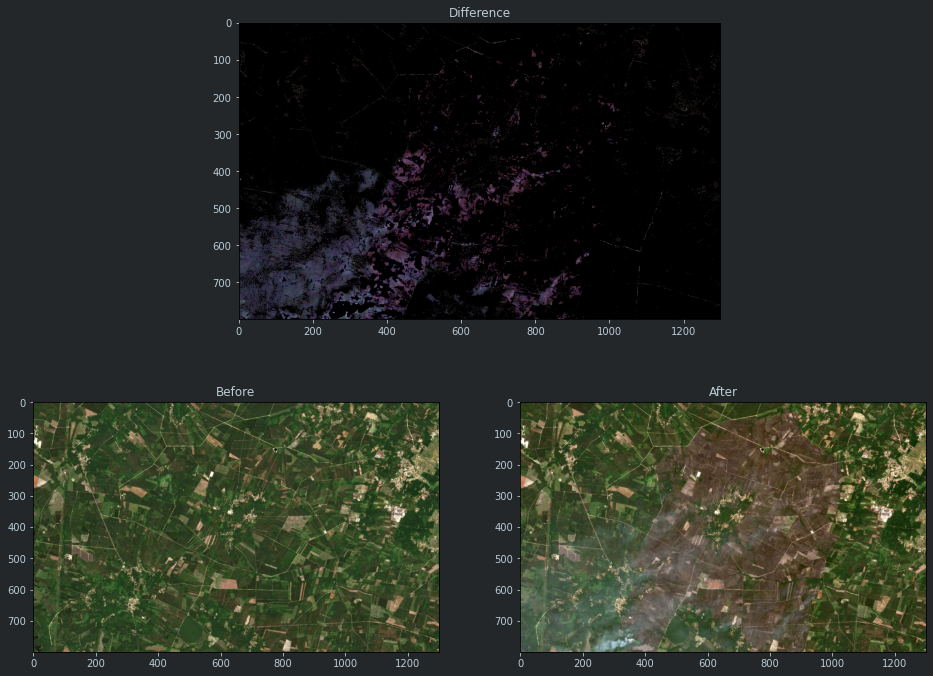

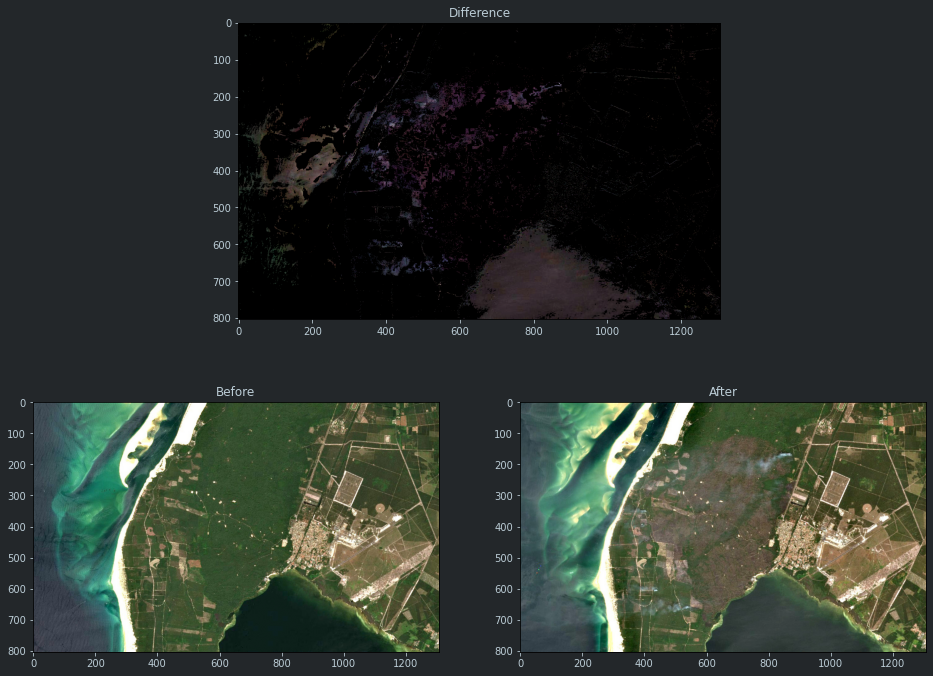

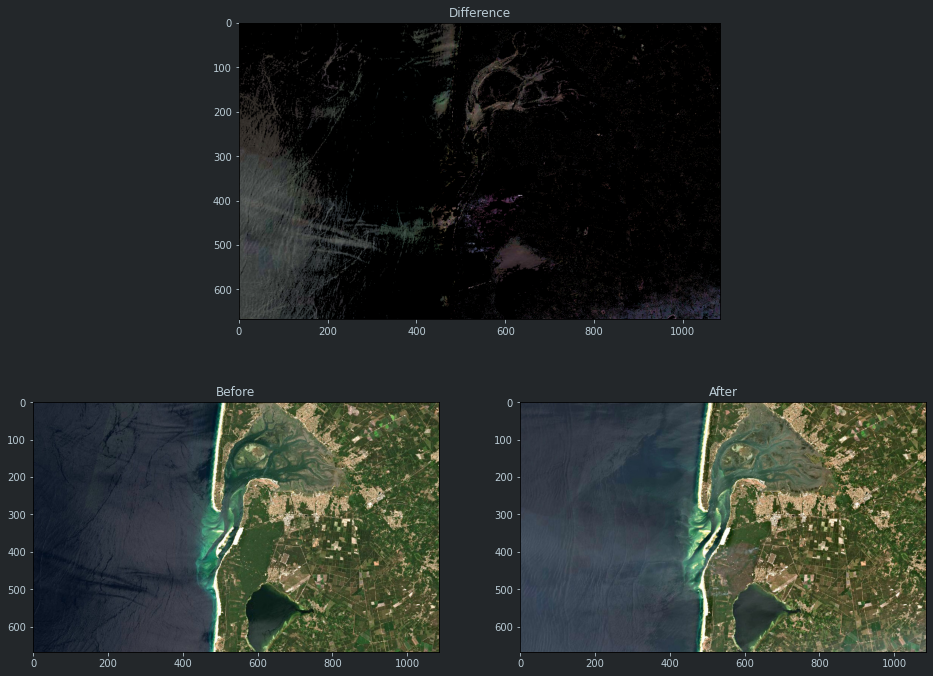

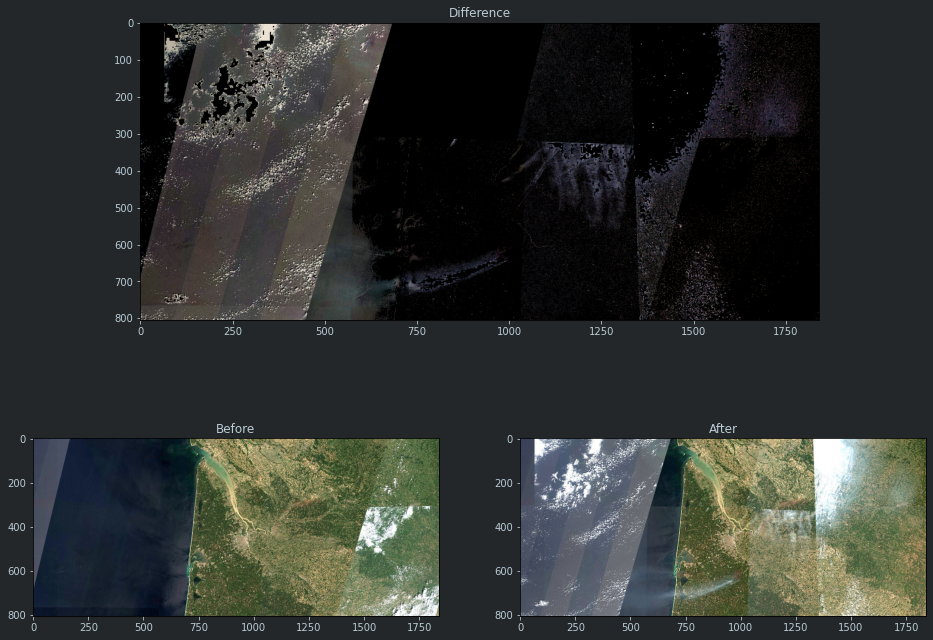

In [6]:
for example in examples:
    plot_trio(*example)

## Fire generation

Looking at this specific example I can identify 3 clear patterns of a fire.
1. We have a bright source
2. A dense smoke trail near the source
3. A more spread out smoke plume of smoke further out

From this we can consider some key parameters we would want to have for each:
1. For all
    1. Size
    2. Brightness
2. Source
    1. Shape (e.g. stretched oval and its orientation)
3. Smoke Trail
    1. Width in degrees as it spreads in a sector pattern see below ( or in other terms wind strength) 
    2. Wind direction
4. Other smoke
    1. I see it as potentially perlin noise and hence its relevant settings possibly translated to more meaningful smoke terms
    2. 1 and 2 from Smoke Trail

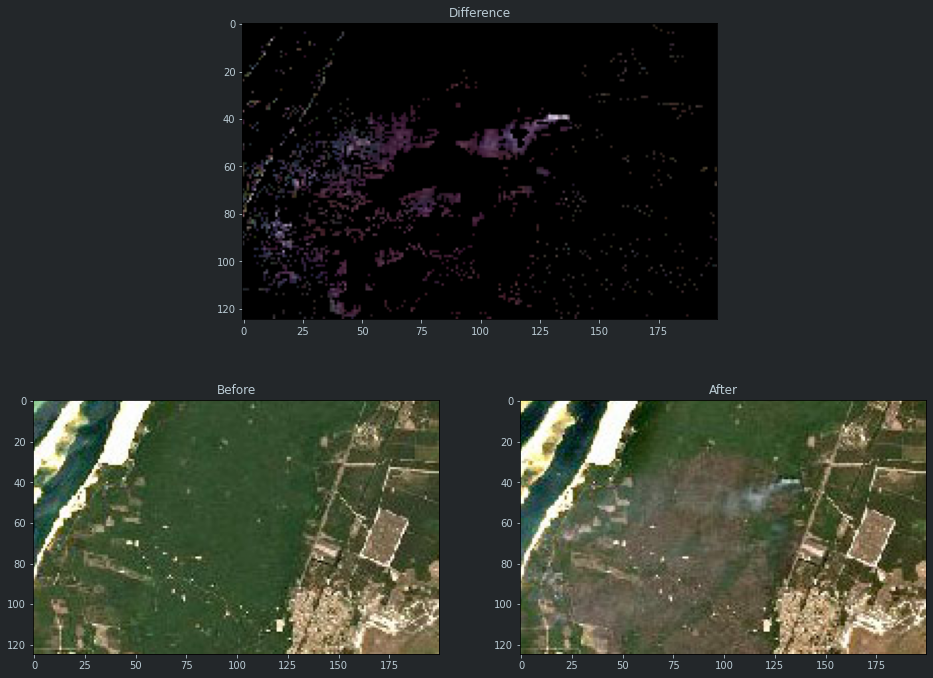

In [7]:
# looking at an example closer up
crop =[img[350:475, 500:700] for img in examples[2]]
plot_trio(*crop)

In [57]:
img = examples[2][0][350:475, 500:700]
print(img)

[[[0.48235294 0.7372549  0.50980392]
  [0.51764706 0.76470588 0.55686275]
  [0.55686275 0.79215686 0.59215686]
  ...
  [0.21568627 0.2627451  0.16862745]
  [0.21960784 0.26666667 0.17254902]
  [0.22352941 0.2745098  0.17254902]]

 [[0.55294118 0.80392157 0.56862745]
  [0.57647059 0.81568627 0.59215686]
  [0.58431373 0.81568627 0.60392157]
  ...
  [0.19607843 0.27058824 0.16078431]
  [0.18039216 0.25490196 0.14509804]
  [0.17254902 0.24705882 0.1372549 ]]

 [[0.50196078 0.7372549  0.48627451]
  [0.58039216 0.78823529 0.56862745]
  [0.63137255 0.81568627 0.63529412]
  ...
  [0.16078431 0.24313725 0.11372549]
  [0.20784314 0.29019608 0.16078431]
  [0.19607843 0.27058824 0.15294118]]

 ...

 [[0.37647059 0.43137255 0.29019608]
  [0.35294118 0.41568627 0.27058824]
  [0.34117647 0.40392157 0.25882353]
  ...
  [0.4627451  0.45882353 0.28627451]
  [0.46666667 0.44705882 0.28235294]
  [0.47843137 0.44313725 0.2745098 ]]

 [[0.32941176 0.38431373 0.24313725]
  [0.29019608 0.34509804 0.20392157]


In [9]:
def expand_to_rgb(img):
    return np.repeat(img[:,:,np.newaxis], 3, axis=2)

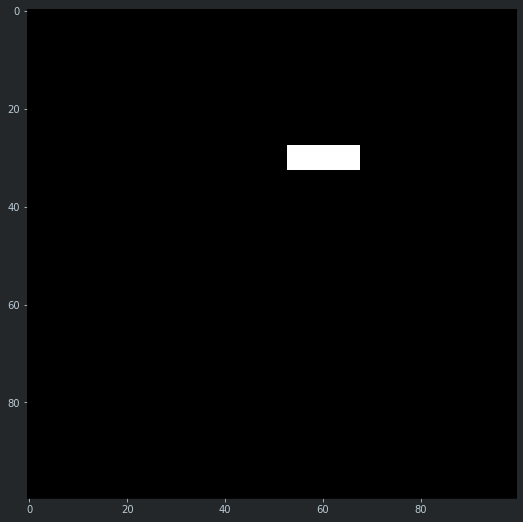

In [10]:
def create_centered_rectangle_mask(size, position, dims):
    circle_mask = np.zeros(size)
    for y in range(circle_mask.shape[0]):
        for x in range(circle_mask.shape[1]):
            if position[1] + dims[1] >= x >= position[1] - dims[1] and position[0] + dims[0] >= y >= position[0] - dims[0]:
                circle_mask[y, x] = 1
    return circle_mask

plt.imshow(create_centered_rectangle_mask((100, 100), (30, 60), (2, 7)), cmap= plt.cm.bone)

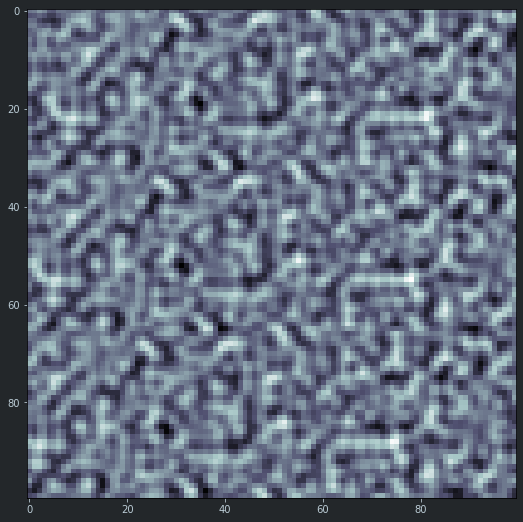

In [11]:
noise = PerlinNoise(octaves=30)
xpix, ypix = (100, 100)
smoke = scale_values(np.array([[noise([i/xpix, j/ypix]) for j in range(ypix)] for i in range(xpix)]))
plt.imshow(scale_values(smoke), cmap=plt.cm.bone)

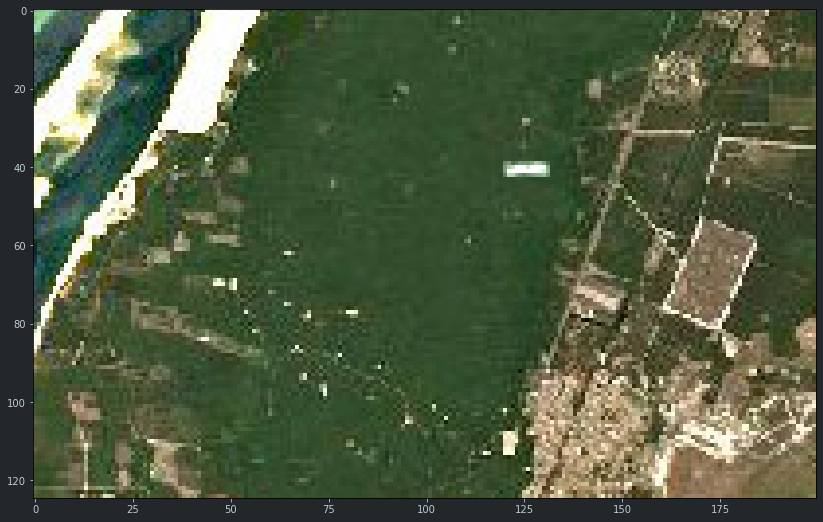

In [12]:
def insert(target, loc, tool): # there is a np.insert but i could not get it to work
    if len(tool.shape) == 2: # if missing color channel dimention
        tool = expand_to_rgb(tool)
        
    copy = target.copy()
    copy[loc[0]: loc[0] + tool.shape[0], loc[1]: loc[1] + tool.shape[1], :] = tool
    return copy

def generate_source(img, position, brightness, size, shape):
    noise = PerlinNoise(octaves=60)
    xpix, ypix = img.shape[:2]
    smoke = scale_values(np.array([[noise([i/xpix, j/ypix]) for j in range(ypix)] for i in range(xpix)]))
    
    
    
    mask = create_centered_rectangle_mask(img.shape[:2], position, (size * shape, size))
    # mask = cv2.GaussianBlur(mask, (11,11), cv2.BORDER_DEFAULT)
    blr_size = max(int(size * 0.3), 2)
    mask = cv2.blur(mask, (blr_size,blr_size))
    
    source = expand_to_rgb(smoke * mask) * brightness
    
    return source

source = generate_source(img, (40, 125), 1.5, 5, 2/7)
plt.imshow(clip(img + source))

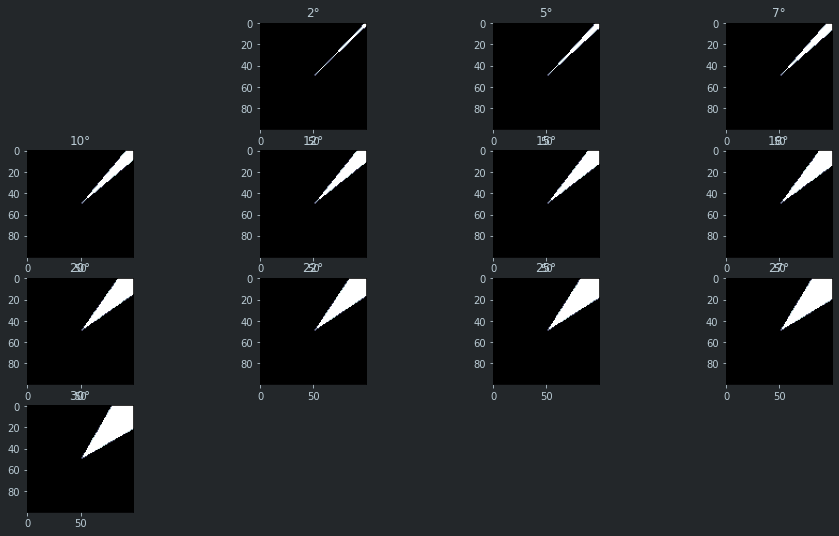

In [13]:

def create_cone_mask(size, position, width, direction):
    cone_mask = np.zeros(size)
    # create the two angles adding an offest for each edge of the cone as well as rotating to bearing coordinates i.e. 0deg is north
    angle1, angle2 = direction - width / 2 - np.pi / 2, direction + width / 2 - np.pi / 2
    # calcluate the gradient line given the angle
    gradient_boundary1, gradient_boundary2 = np.tan( angle1), np.tan(angle2)
    for y in range(cone_mask.shape[0]):
        for x in range(cone_mask.shape[1]):
            # get the side that the pixel is on for both lines
            divide1, divide2 = (y - position[0]) <= gradient_boundary1 * (x - position[1]), y - position[0] >= gradient_boundary2 * (x - position[1])
            # combine with threshold function that tells us if we want the space above or below the dividing line "sin(theta - pi/2) >= 0"
            if not( (divide1 != (np.sin(angle1 - np.pi / 2) >= 0)) or (divide2 != (np.sin(angle2 - np.pi / 2) >= 0))):
                cone_mask[y, x] = 1
    
    return cone_mask


fig = plt.figure()
items = 12
for i in range(1, items + 1):
    direction = 2 * np.pi * i / items / 12
    ax = fig.add_subplot(4, 4, i + 1, title=f'{np.rad2deg(direction):0.0f}°')
    ax.imshow(create_cone_mask((100, 100), (50, 50), direction, np.deg2rad(45)), cmap=plt.cm.bone)

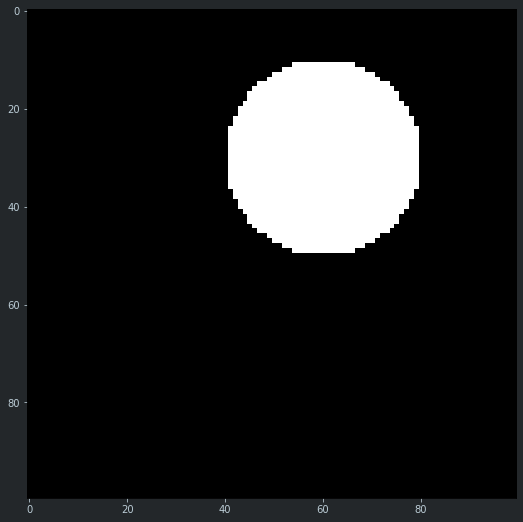

In [14]:
def create_circle_mask(size, position, radius):
    circle_mask = np.zeros(size)
    for y in range(circle_mask.shape[0]):
        for x in range(circle_mask.shape[1]):
            if radius ** 2 > (x - position[1]) ** 2 + (y - position[0]) ** 2:
                circle_mask[y, x] = 1
    return circle_mask

plt.imshow(create_circle_mask((100, 100), (30, 60), 20), cmap= plt.cm.bone)

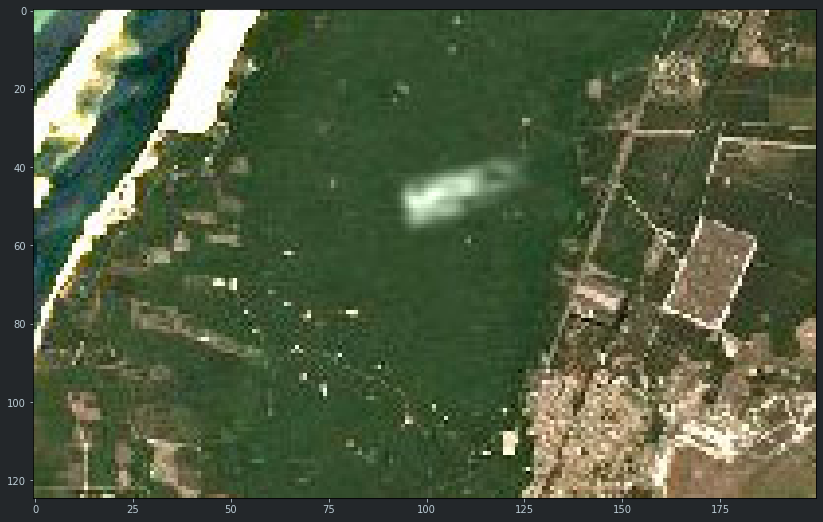

In [15]:
def generate_trail(img, position, brightness, width, direction, radius):
    trail = np.zeros_like(img)
    
    
    noise = PerlinNoise(octaves=30)
    xpix, ypix = img.shape[:2]
    smoke = scale_values(np.array([[noise([i/xpix, j/ypix]) for j in range(ypix)] for i in range(xpix)]))
    
    
    cone_mask = create_cone_mask(img.shape[:2], position, width, direction)
    circle_mask = create_circle_mask(img.shape[:2], position, radius)
    
    mask = cone_mask * circle_mask
    # mask = cv2.GaussianBlur(mask, (11,11), cv2.BORDER_DEFAULT)
    blr_size = int(radius * 0.3)
    mask = cv2.blur(mask, (blr_size,blr_size))
    
    trail = expand_to_rgb(smoke * mask) * brightness
    
    return trail

trail = generate_trail(img, (40, 125), 2, np.deg2rad(15), np.deg2rad(250), 30)
plt.imshow(clip(img + trail)) # TODO: Not sure why cliping in this case causes dark spots 

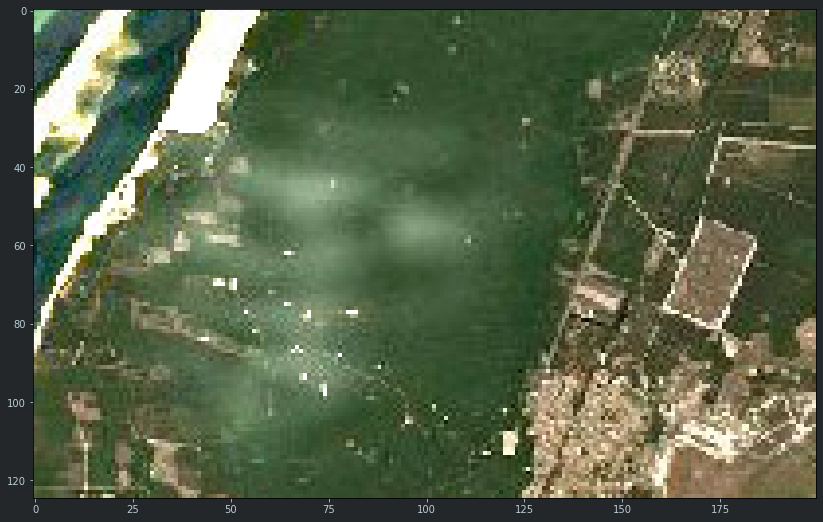

In [16]:
def generate_plume(img, position, brightness, width, direction, radius):
    plume = np.zeros_like(img)
    
    
    noise = PerlinNoise(octaves=10)
    xpix, ypix = img.shape[:2]
    smoke = scale_values(np.array([[noise([i/xpix, j/ypix]) for j in range(ypix)] for i in range(xpix)]))
    
    
    cone_mask = create_cone_mask(img.shape[:2], position, width, direction)
    circle_mask = create_circle_mask(img.shape[:2], position, radius)
    
    mask = cone_mask * circle_mask
    # mask = cv2.GaussianBlur(mask, (11,11), cv2.BORDER_DEFAULT)
    blr_size = int(radius * 0.3)
    mask = cv2.blur(mask, (blr_size,blr_size))
    
    plume = expand_to_rgb(smoke * mask) * brightness
    
    return plume

plume = generate_plume(img, (40, 125), 0.4, np.deg2rad(60), np.deg2rad(250), 100)
plt.imshow(clip(img + plume))

0.0 1.0


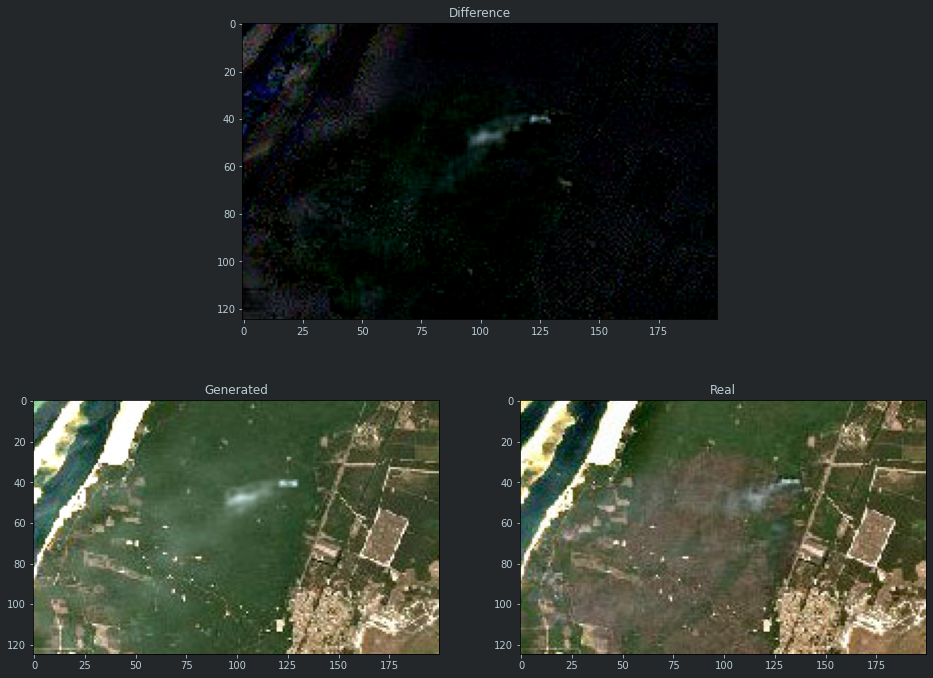

In [17]:
def generate_fire(img, position, direction, blue=1.2): # TODO: add wind speed which translates to width for trail and plume
    source = generate_source(img, position, 0.8, 4, 1/4)
    trail = generate_trail(img, position, 1, np.deg2rad(15), direction, 30)
    plume = generate_plume(img, position, 0.2, np.deg2rad(60), direction, 150)
    fire = source + trail + plume
    fire[:, : ,2] *= blue # boost blue channel
    return clip(img + fire)

img_with_fire = generate_fire(img, (40, 125), np.deg2rad(250))
print(img_with_fire.min(), img_with_fire.max())
plot_trio(img_with_fire, crop[1], clip(img_with_fire - crop[1]), labels=('Generated', 'Real', 'Difference'))

In [18]:
def get_random_position(img):
    # temporary solution for any random green pixel.
    # TODO: find a way to not generate fire on water bodies
    mask = img[:, :, 1] < 0.5
    # plt.imshow(mask, cmap=plt.cm.bone)
    y, x = np.where(mask)
    index = np.random.randint(len(x))
    return y[index], x[index]

get_random_position(img)


(110, 97)

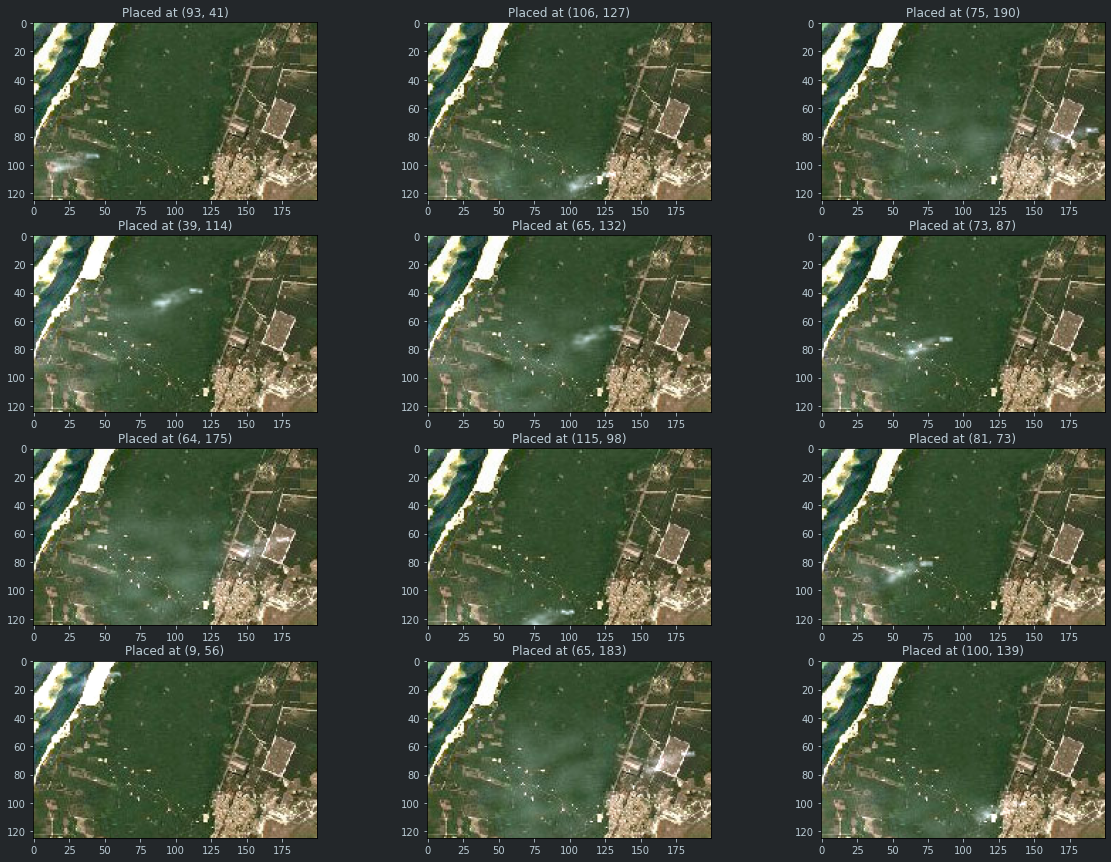

In [19]:
fig = plt.figure(figsize=(20, 15))

for i in range(12):
    pos = get_random_position(img)
    ax = fig.add_subplot(4, 3, i + 1, title=f'Placed at {pos}')
    ax.imshow(generate_fire(img, pos, np.deg2rad(250)))

[[[0.48235294 0.7372549  0.50980392]
  [0.51764706 0.76470588 0.55686275]
  [0.55686275 0.79215686 0.59215686]
  ...
  [0.21568627 0.2627451  0.16862745]
  [0.21960784 0.26666667 0.17254902]
  [0.22352941 0.2745098  0.17254902]]

 [[0.55294118 0.80392157 0.56862745]
  [0.57647059 0.81568627 0.59215686]
  [0.58431373 0.81568627 0.60392157]
  ...
  [0.19607843 0.27058824 0.16078431]
  [0.18039216 0.25490196 0.14509804]
  [0.17254902 0.24705882 0.1372549 ]]

 [[0.50196078 0.7372549  0.48627451]
  [0.58039216 0.78823529 0.56862745]
  [0.63137255 0.81568627 0.63529412]
  ...
  [0.16078431 0.24313725 0.11372549]
  [0.20784314 0.29019608 0.16078431]
  [0.19607843 0.27058824 0.15294118]]

 ...

 [[0.37647059 0.43137255 0.29019608]
  [0.35294118 0.41568627 0.27058824]
  [0.34117647 0.40392157 0.25882353]
  ...
  [0.4627451  0.45882353 0.28627451]
  [0.46666667 0.44705882 0.28235294]
  [0.47843137 0.44313725 0.2745098 ]]

 [[0.32941176 0.38431373 0.24313725]
  [0.29019608 0.34509804 0.20392157]


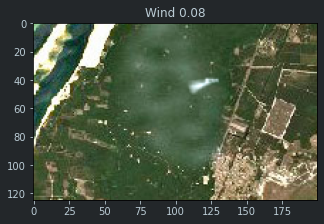

In [76]:
def scale_variable(value,target_min=0, target_max=1, a_min=0, a_max=1):
    return (value - a_min) / (a_max - a_min) * (target_max - target_min) + target_min

def calculate_wind(size, wind):

    diag = np.sqrt(size[0] ** 2 + size[1] ** 2)
    trail_angle = np.deg2rad(scale_variable(wind, 30, 10))
    trail_length = scale_variable(wind, diag / 20, diag / 4)
    
    plume_angle = np.deg2rad(scale_variable(wind, 180, 40))
    plume_length = scale_variable(wind, diag / 5, diag / 1)
    
    return (trail_angle, trail_length), (plume_angle, plume_length)


def generate_fire_with_wind(img, position, direction, wind, blue=1.2):
    trail_params, plume_params = calculate_wind(img.shape, wind)
    source = generate_source(img, position, 0.8, 4, 1/4)
    trail = generate_trail(img, position, 1, trail_params[0], direction, trail_params[1])
    plume = generate_plume(img, position, 0.2, plume_params[0], direction, plume_params[1])
    fire = source + trail + plume
    fire[:, : ,2] *= blue # boost blue channel
    return clip(img + fire)

fig = plt.figure(figsize=(20, 15))
for i in range(1):
    wind = (i + 1) / 12
    ax = fig.add_subplot(4, 3, i + 1, title=f'Wind {wind:0.2f}')
    ax.imshow(generate_fire_with_wind(img, (40, 125), np.deg2rad(250), wind))
    print(img)

### Random value generator
```
values: pixel position, wind direction and plume/trail width
```

In [126]:
class Random:
    def __init__(self, **kwargs):
        # normal holds the mu-sigma pairs 
        # for all normally distributed variables 
        self.normal = {
            var : params for var, params in zip(
                ['wind_direction', 'trail_width', 'plume_width'],
                [*kwargs.values()]
            )
        }
    
    def random(self, var, args = None):
        if var in self.normal:
            mu, sigma = self.normal[var]
            value = np.rint(
                np.random.normal(loc = mu, scale = sigma, size = 1).item()
            )
        elif var == 'position':
            value = self._position(args)
        return value
    
    def _position(self, img):
        if img is None:
            return
        mask = img[:, :, 1] < 227
        y, x = np.where(mask)
        index = np.random.randint(len(x))
        return y[index], x[index]

In [22]:
rd = Random(wind_direction = (180, 100), trail_width = (15, 5), plume_width = (60, 20))
wind_direction = rd.random('wind_direction')
print(wind_direction)

306.0


```
generate_fire with randomly generated trail and plume widths
```

In [23]:
def generate_fire(img, position, direction, rand_gen, blue=1.2): 
    source = generate_source(img, position, 0.8, 4, 1/4)
    t_width, p_width = [*map(rand_gen.random, ['trail_width', 'plume_width'])]
    trail = generate_trail(img, position, 1, np.deg2rad(t_width), direction, 30)
    plume = generate_plume(img, position, 0.2, np.deg2rad(p_width), direction, 150)
    fire = source + trail + plume
    fire[:, : ,2] *= blue 
    return clip(img + fire)

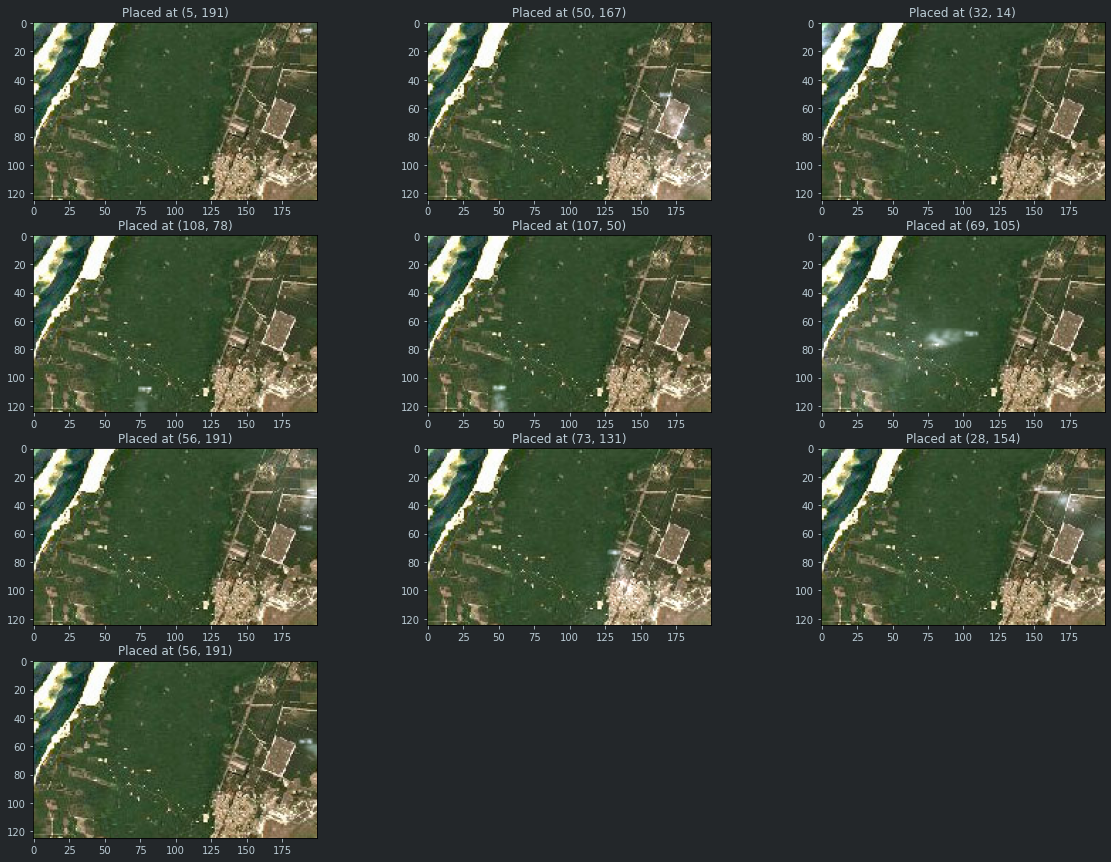

In [24]:
fig = plt.figure(figsize=(20, 15))

for i in range(10):
    rd = Random(wind_direction = (180, 100), trail_width = (15, 5), plume_width = (60, 20))
    w_direction = rd.random('wind_direction')
    pos = rd.random('position', img)
    ax = fig.add_subplot(4, 3, i + 1, title=f'Placed at {pos}')
    ax.imshow(generate_fire(img, pos, np.deg2rad(w_direction), rd))


In [144]:
def datasetGen(dataset_config):
    #Create empty metadata DataFrame
    df = pd.DataFrame(columns=['img_name', 'position', 'direction'])
    
    #Load clean dataset
    root = dataset_config["root"]
    relative_path = dataset_config["relative_paths"]["cleaned"]
    g_expr = os.path.join(root, relative_path, "*/*/*")
    cleanImgs = glob(g_expr)
    
    random.shuffle(cleanImgs)
    
    #Create positive dataset
    for img_path in cleanImgs[:30]:
        clean_img = cv2.imread(img_path)
        
        #Normalize for random variables TODO: Fix normalisation
        norm = np.copy(clean_img)
        norm_img = cv2.normalize(clean_img, norm, 0, 1, cv2.NORM_MINMAX, cv2.CV_32F)
        
        rd = Random(wind_direction = (180, 100), trail_width = (15, 5), plume_width = (60, 20))
        w_direction = rd.random('wind_direction')
        pos = rd.random('position', norm_img)
        direction = np.deg2rad(w_direction) 
        fire_img = generate_fire(norm_img, pos, direction, rd)
        
        #Save img
        path_components = img_path.split(os.path.sep)
        img_name = path_components[-1].strip()
        try:
            clean_index = path_components.index("cleaned")
            path_components[clean_index] = "positive"
            path_components = path_components[:2] + [path_components[-1]]
            sep = os.path.sep
            path_str = sep.join(path_components)
            exit_code = cv2.imwrite(path_str, fire_img * 255)
            if exit_code:
                print(img_name, "saved successfully!")
        except ValueError:
            print("Skipping", img_name)
        
        #Append to metadataDataFrame
        df.loc[len(df.index)] = [img_name, pos, direction]
    
    #Save metadata DataFrame object as csvFile TODO: Fix for linux pathing so it goes in correct directory
    df.to_csv("positive_Metadata.csv")
    
    #Create negative dataset
    for img_path in cleanImgs[30:240]:
        clean_img = cv2.imread(img_path)
        path_components = img_path.split(os.path.sep)
        img_name = path_components[-1].strip()
        
        try:
            clean_index = path_components.index("cleaned")
            path_components[clean_index] = "negative"
            path_components = path_components[:2] + [path_components[-1]]
            sep = os.path.sep
            path_str = sep.join(path_components)
            exit_code = cv2.imwrite(path_str, clean_img)
            if exit_code:
                print(img_name, "saved successfully!")
        except ValueError:
            print("Skipping", img_name)


positive
a204.jpg saved successfully!
positive
174980_sat_52.jpg saved successfully!
positive
897901_sat_24.jpg saved successfully!
positive
134465_sat_76.jpg saved successfully!
positive
605764_sat_72.jpg saved successfully!
positive
772452_sat_25.jpg saved successfully!
positive
15573_sat_31.jpg saved successfully!
positive
392711_sat_17.jpg saved successfully!
positive
e141.jpg saved successfully!
positive
a150.jpg saved successfully!
positive
810749_sat_54.jpg saved successfully!
positive
b263.jpg saved successfully!
positive
621206_sat_72.jpg saved successfully!
positive
b369.jpg saved successfully!
positive
428327_sat_42.jpg saved successfully!
positive
b268.jpg saved successfully!
positive
691384_sat_72.jpg saved successfully!
positive
277994_sat_17.jpg saved successfully!
positive
825816_sat_03.jpg saved successfully!
positive
a070.jpg saved successfully!
positive
533952_sat_75.jpg saved successfully!
positive
628479_sat_62.jpg saved successfully!
positive
981852_sat_42.jpg sav

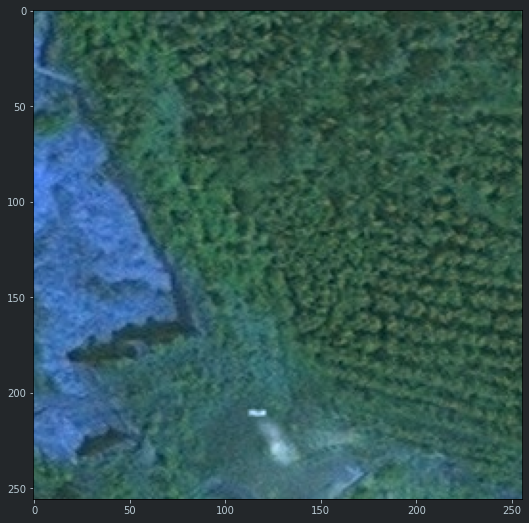

In [145]:
DATASET_CONFIG = {
    "root" : "../datasets",
    "relative_paths" : {
        "cleaned" : "cleaned",
        "positive" : "positive", 
        "negative" : "negative"
    }
}

datasetGen(DATASET_CONFIG)

[]
